In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys

sys.path.append("../../")

In [336]:
from tokenizers import Tokenizer
import sys

import matplotlib.pyplot as plt
import numpy as np
import collections
import torch

from ChEmbed.data import chembldb, smiles_dataset, chembed_tokenize
from ChEmbed.training import trainer
from ChEmbed.modules import simple_rnn

from ChEmbed import plots, utilities

In [20]:
chembl_raw = chembldb.ChemblDB()
chembl_smiles = chembl_raw._load_or_download()["canonical_smiles"]

In [21]:
tokenizer = chembed_tokenize.load_chembed_tokenizer(filepath = "../data/tokenizers/tokenizer-chembldb-16-06-2025.json")

In [339]:
chembl_dataset = smiles_dataset.SMILESDataset(
    smiles_list = chembl_smiles,
    tokenizer = tokenizer
)

chembl_mini = chembl_dataset = smiles_dataset.SMILESDataset(
    smiles_list = chembl_smiles[:128],
    tokenizer = tokenizer
)

In [ ]:
model = simple_rnn.simpleRNN(
    # Mandatory
    num_hiddens = 64,
    vocab_size = len(tokenizer),
    # tuning
    learning_rate = 0.2,
    weight_decay = 0.01
)

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [321]:
chembl_dataset[0].type(torch.float32)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [322]:
model.forward(next(iter(chembl_dataset)))

tensor([[ 0.0003, -0.0046,  0.0593,  ...,  0.0204,  0.0204,  0.0204],
        [ 0.0486,  0.0739,  0.1220,  ...,  0.0388,  0.0388,  0.0388],
        [-0.1826, -0.1086, -0.0165,  ..., -0.1344, -0.1344, -0.1344],
        ...,
        [ 0.0489,  0.0341, -0.0702,  ..., -0.0475, -0.0475, -0.0475],
        [-0.1557, -0.1054, -0.1742,  ...,  0.0080,  0.0080,  0.0080],
        [ 0.0045, -0.0613,  0.1106,  ...,  0.0238,  0.0238,  0.0238]],
       grad_fn=<TransposeBackward0>)

In [332]:
def predict(input, num_preds, model, dataset, device=None):
    state, outputs = None, [input[0]]

    # predict input + num_preds tokens
    for i in range(len(input) + num_preds - 1):
        X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)
        
        rnn_outputs, state = model.rnn(X, state)

        if i < len(input) - 1:
            outputs.append(input[i + 1])
        else:
            Y = dataset.tokenizer.decode(model.linear(rnn_outputs).argmax())
            outputs.append(Y)

    return ''.join(outputs)
            

In [333]:
print(predict("CCC", 10, model, chembl_dataset))

/var/folders/ql/140bddls19x4s8xyk9nrwyd00000gn/T/ipykernel_16882/1428639691.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)


CCCc1cc2ccc1cc2ccc1cc2ccc1cc2ccc1cc2cc


In [341]:
model_trainer = trainer.Trainer(max_epochs=16, init_random=42)
model_trainer.fit(model, chembl_mini)

Training batch 1/2... (Epoch 1/16)
Training batch 2/2... (Epoch 1/16)
Training batch 1/2... (Epoch 2/16)
Training batch 2/2... (Epoch 2/16)
Training batch 1/2... (Epoch 3/16)
Training batch 2/2... (Epoch 3/16)
Training batch 1/2... (Epoch 4/16)
Training batch 2/2... (Epoch 4/16)
Training batch 1/2... (Epoch 5/16)
Training batch 2/2... (Epoch 5/16)
Training batch 1/2... (Epoch 6/16)
Training batch 2/2... (Epoch 6/16)
Training batch 1/2... (Epoch 7/16)
Training batch 2/2... (Epoch 7/16)
Training batch 1/2... (Epoch 8/16)
Training batch 2/2... (Epoch 8/16)
Training batch 1/2... (Epoch 9/16)
Training batch 2/2... (Epoch 9/16)
Training batch 1/2... (Epoch 10/16)
Training batch 2/2... (Epoch 10/16)
Training batch 1/2... (Epoch 11/16)
Training batch 2/2... (Epoch 11/16)
Training batch 1/2... (Epoch 12/16)
Training batch 2/2... (Epoch 12/16)
Training batch 1/2... (Epoch 13/16)
Training batch 2/2... (Epoch 13/16)
Training batch 1/2... (Epoch 14/16)
Training batch 2/2... (Epoch 14/16)
Training b

In [342]:
print(predict("CCC", 10, model, chembl_dataset))

/var/folders/ql/140bddls19x4s8xyk9nrwyd00000gn/T/ipykernel_16882/1428639691.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)


CCC<pad><pad><pad><pad><pad><pad><pad><pad><pad>


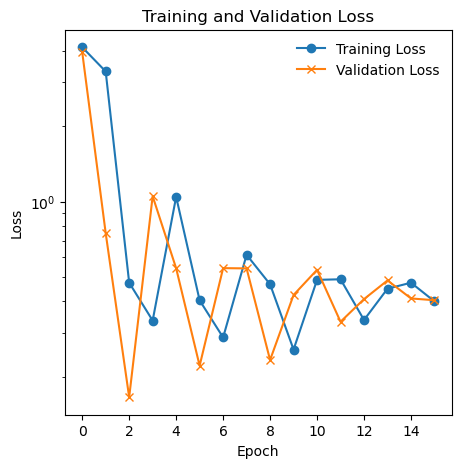

In [343]:
losses = utilities.extract_training_losses(model_trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale('log')